注意力
起因: 在心理学中, 人类根据随意线索和不随意线索选择注意点

随机线索（自主性线索，Volitional Cues）​​
指模型或任务主动设定的、与当前目标相关的动态信息。
例如，在注意力机制中，模型通过可学习的“查询向量”（query）来主动选择需要关注的内容，类似于人类根据任务需求有意识地聚焦于特定区域。
​不随意线索（非自主性线索，Involuntary Cues）​​
指输入数据中固有的、被动响应的显著特征。
例如，图像的边缘、纹理或颜色对比度等底层特征，会自然吸引模型的注意，类似于人类被突然的闪光或鲜艳色彩吸引的无意识反应。

而我们之前所说的卷积/全连接/池化层都只考虑不随意线索

所以, 我们加入注意力机制来显式的建模随机线索, 其中:
随机线索被称为一个 查询(query)
每一个输入现在变成了一个值(value)和一个不随意线索(key)的对
然后, 我们通过 注意力池化层 来有偏向性的选择某些输入
query会在attention pool中查询"感兴趣"的key, 从而引出更合理的value权重:

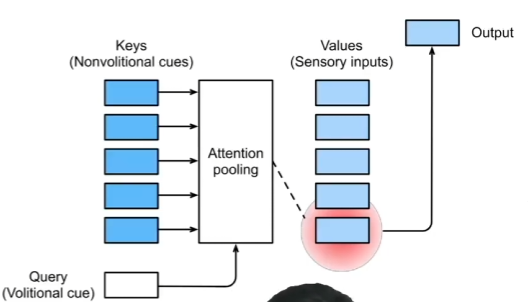

非参的注意力池化层
最简单的解决方案:就用平均池化层, 并没有考虑注意力的特性.
更好的解决方案: 针对查询的x, xi与它距离越近, yi的权重越大

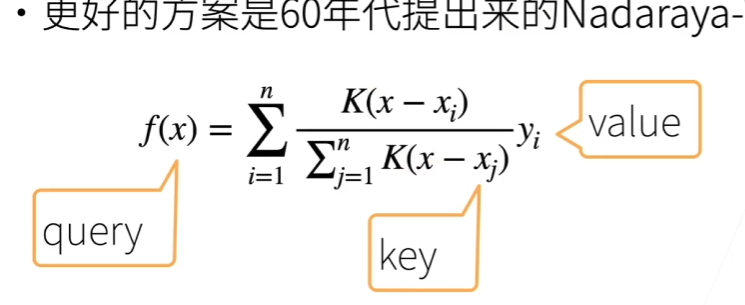

那么产生了一个问题: K(核)怎么选
高斯核: 等于对差的平方的softmax

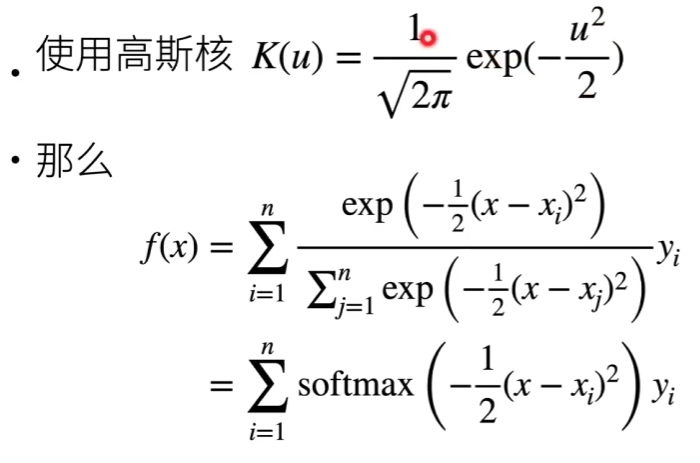

这是一个较早期的统计学结论, 现在为了引入学习的能力, 我们再设置一个可以学习的参数w

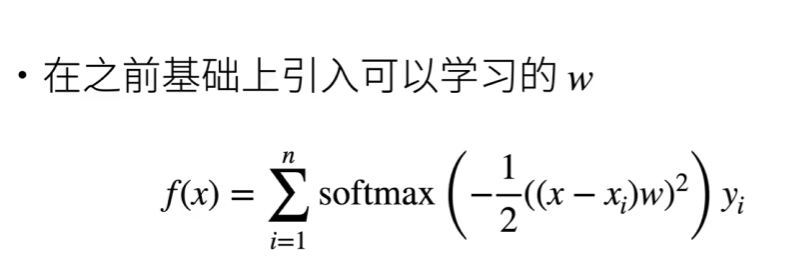

心理学认为人通过随意线索和不随意线索选择注意点
注意力机制中，通过查询(随意线索)和Key(不随意线
索)来有偏向性的选择输入
可以一般的写作f(X)=∑a(x，x)y，这里a(x，x)是注意力权重
我
早在60年代就有非参数的注意力机制
接下来我们会介绍多个不同的权重设计

In [ ]:
# 代码实现
import torch
from torch import nn
from d2l import torch as d2l

In [ ]:
# 数据集的生成
n_train = 50
x_train, _ = torch.sort(torch.rand(n_train) * 5)

def f(x):
    return 2 * torch.sin(x) + x**0.8

y_train = f(x_train) + torch.normal(0.0, 0.5, (n_train,))
x_test = torch.arange(0, 5, 0.1)
y_truth = f(x_test)
n_test = len(x_test)
n_test

In [ ]:
def plot_kernel_reg(y_hat):
    d2l.plot(x_test, [y_truth, y_hat], 'x', 'y', legend=['Truth', 'Pred'],
             xlim=[0, 5], ylim=[-1, 5])
    d2l.plt.plot(x_train, y_train, 'o', alpha=0.5);

y_hat = torch.repeat_interleave(y_train.mean(), n_test)
plot_kernel_reg(y_hat)

In [ ]:
# 画一下虚拟点/真相/预测(此时还没开始预测)
X_repeat = x_test.repeat_interleave(n_train).reshape((-1, n_train))
attention_weights = nn.functional.softmax(-(X_repeat - x_train)**2 / 2, dim=1)
y_hat = torch.matmul(attention_weights, y_train)
plot_kernel_reg(y_hat)

In [ ]:
# 非参数注意力池化(汇聚) -- 注意, 由于这是一个概率学的公式, 我们不作学习就得出了最终的曲线
# 将每个测试点 x_test 重复 n_train 次，生成形状为 (n_test, n_train) 的张量，便于与 x_train 逐元素计算距离
# 若 x_test = [a, b]，x_train = [c, d, e]，则 X_repeat 为：
# [[a, a, a], [b, b, b]]
X_repeat = x_test.repeat_interleave(n_train).reshape((-1, n_train))
# 这一段是上面高斯核的最终公式
attention_weights = nn.functional.softmax(-(X_repeat - x_train)**2 / 2, dim=1)
# 加权预测输出: 对训练标签 y_train 进行注意力加权求和，得到预测值 y_hat
y_hat = torch.matmul(attention_weights, y_train)
plot_kernel_reg(y_hat)

In [ ]:
# 看看权重
d2l.show_heatmaps(
    attention_weights.unsqueeze(0).unsqueeze(0),
    xlabel='Sorted training inputs', ylabel='Sorted testing inputs')

In [ ]:
# 带参数的注意力汇聚
# 带参数注意力汇聚 假定两个张量的形状分别是 (n,a,b)和 (n,b,c)
# 则它们的批量矩阵乘法输出的形状为 (n,a,c)
X = torch.ones((2, 1, 4))
Y = torch.ones((2, 4, 6))
torch.bmm(X, Y).shape

In [ ]:
# 使用小批量矩阵乘法来计算小批量数据中的加权平均值
weights = torch.ones((2, 10)) * 0.1
values = torch.arange(20.0).reshape((2, 10))
torch.bmm(weights.unsqueeze(1), values.unsqueeze(-1))

In [ ]:
# 带参数的注意力汇聚, 和之前的差别: 多了一个参数w
class NWKernelRegression(nn.Module):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)
        self.w = nn.Parameter(torch.rand((1,), requires_grad=True))

    def forward(self, queries, keys, values):
        queries = queries.repeat_interleave(keys.shape[1]).reshape(
            (-1, keys.shape[1]))
        self.attention_weights = nn.functional.softmax(
            -((queries - keys) * self.w)**2 / 2, dim=1)
        return torch.bmm(self.attention_weights.unsqueeze(1),
                         values.unsqueeze(-1)).reshape(-1)

In [ ]:
# 将训练数据集转换为键和值
X_tile = x_train.repeat((n_train, 1))
Y_tile = y_train.repeat((n_train, 1))
keys = X_tile[(1 - torch.eye(n_train)).type(torch.bool)].reshape(
    (n_train, -1))
values = Y_tile[(1 - torch.eye(n_train)).type(torch.bool)].reshape(
    (n_train, -1))

In [ ]:
# 训练带参数的注意力汇聚模型
net = NWKernelRegression()
loss = nn.MSELoss(reduction='none')
trainer = torch.optim.SGD(net.parameters(), lr=0.5)
animator = d2l.Animator(xlabel='epoch', ylabel='loss', xlim=[1, 5])

for epoch in range(5):
    trainer.zero_grad()
    l = loss(net(x_train, keys, values), y_train) / 2
    l.sum().backward()
    trainer.step()
    print(f'epoch {epoch + 1}, loss {float(l.sum()):.6f}')
    animator.add(epoch + 1, float(l.sum()))

In [ ]:
# 预测结果绘制
keys = x_train.repeat((n_test, 1))
values = y_train.repeat((n_test, 1))
y_hat = net(x_test, keys, values).unsqueeze(1).detach()
plot_kernel_reg(y_hat)

In [ ]:
# 曲线在注意力权重较大的区域变得更不平滑
d2l.show_heatmaps(
    net.attention_weights.unsqueeze(0).unsqueeze(0),
    xlabel='Sorted training inputs', ylabel='Sorted testing inputs')

注意力分数
起因: 之前我们所说的可学习的参数就是加了个w, 很明显我们可以设置更合理的设置注意力权重来使得模型性能更强大
什么是注意力分数:对于高斯核的公式来说, -1/2(x-xi)^2就是注意力分数

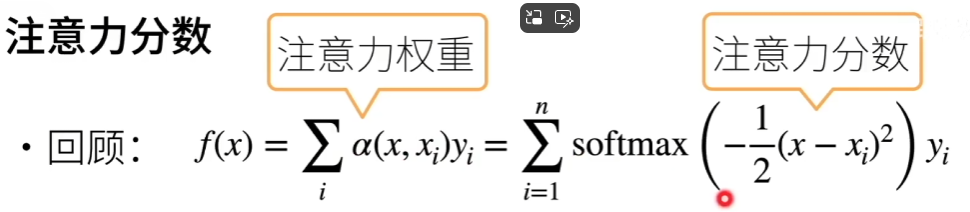
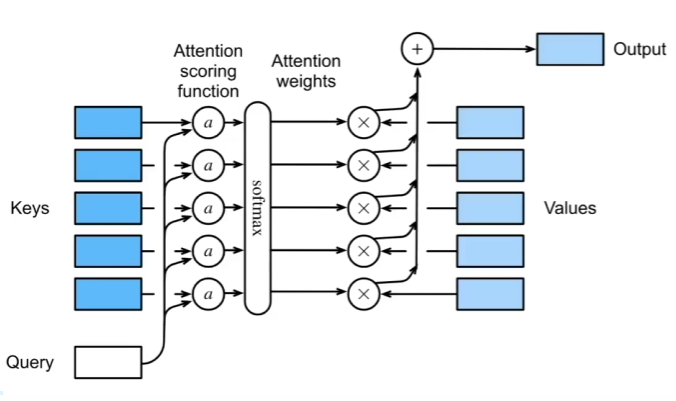

在我们得到注意力的过程中, q是查询向量, a是注意力分数函数, a接收了原有的key和查询q之后
再进行softmax, 就得到注意力的权重, 再跟每个value加权
设计不同的注意力池化层: 都会包含query q, key-value (ki, vi)
注意力池化层就是: Σα(q,ki)vi
其中, α(q,ki)=softmax(a(q,ki)), a(q,ki)就是注意力分数

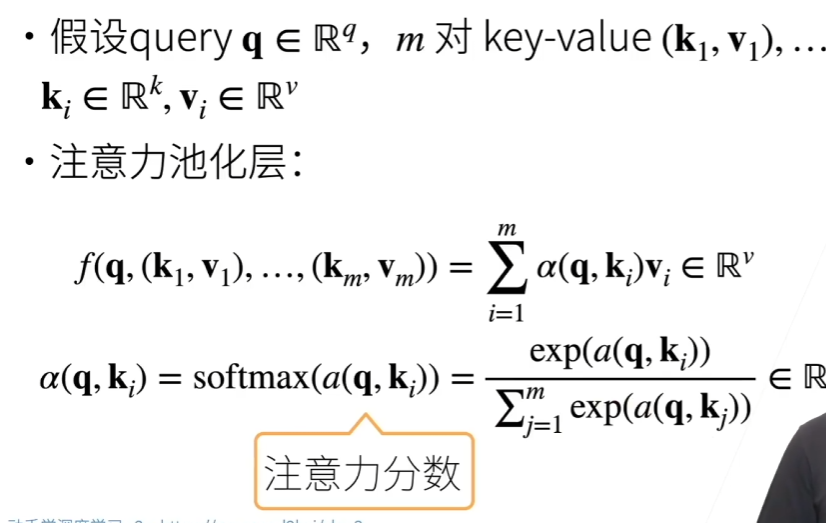

可加注意力(additive attention)
针对k和q的长度设计两个可学的参数Wk(h×k)和Wq(h×q)
也就是将k和q合并起来后放入一个隐藏层(激活函数)中

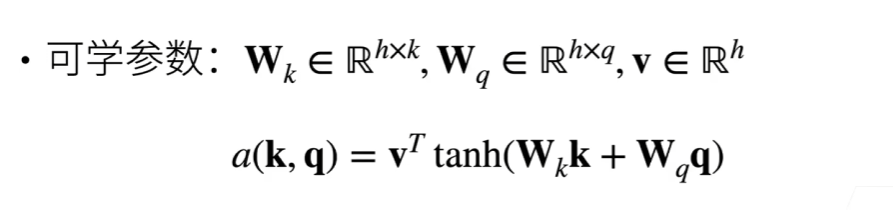

点积注意力
如果q和k的长度是一样的, 可以采用不学东西的方法, 直接去q,k的点积/长度开根

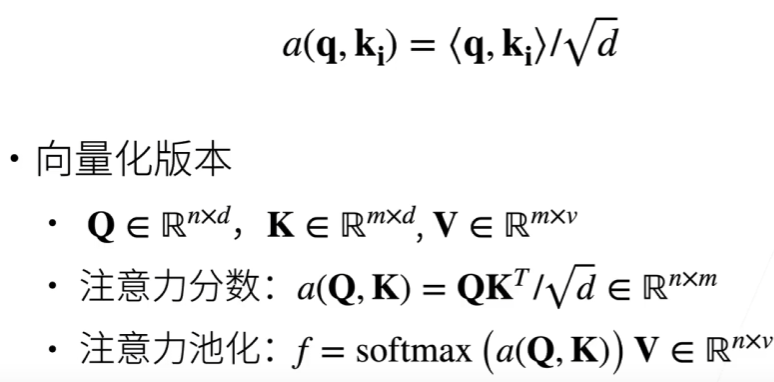

注意力分数表征了query和key的相似度, 注意力权重是分数的softmax结果

In [ ]:
# 代码实现
import math
import torch
from torch import nn
from d2l import torch as d2l

In [ ]:
def masked_softmax(X, valid_lens):
    """通过在最后一个轴上遮蔽元素来执行 softmax 操作"""
    # 无掩码情况: 直接对最后一个维度 (dim=-1) 应用标准的 softmax 操作并返回结果; valid_lens:有效的长度
    if valid_lens is None:
        return nn.functional.softmax(X, dim=-1)
    else:
        # 保存输入张量 X 的原始形状，以便后续处理完成后可以恢复形状
        shape = X.shape
        # 如果 valid_lens 是一维张量
        if valid_lens.dim() == 1:
            # 通过 repeat_interleave 将其扩展为与输入张量 X 的第二维（通常是序列长度）相同的形状
            valid_lens = torch.repeat_interleave(valid_lens, shape[1])
        else:
            # 处理多维 valid_lens​：如果 valid_lens 是多维的，则将其展平为一维
            valid_lens = valid_lens.reshape(-1)
        # 将输入 X 重塑为二维张量;
        # 使用 sequence_mask 函数应用掩码
        # 将超出 valid_lens 指定长度的位置设置为一个极小的值（-1e6），这样在 softmax 中这些位置将接近零概率
        X = d2l.sequence_mask(X.reshape(-1, shape[-1]), valid_lens,
                              value=-1e6)
        return nn.functional.softmax(X.reshape(shape), dim=-1)

In [ ]:
class AdditiveAttention(nn.Module):
    """加性注意力"""
    # key_size：键向量的维度
    # query_size：查询向量的维度
    # num_hiddens：隐藏层大小
    # dropout：dropout 概率
    def __init__(self, key_size, query_size, num_hiddens, dropout, **kwargs):
        super(AdditiveAttention, self).__init__(**kwargs)
        self.W_k = nn.Linear(key_size, num_hiddens, bias=False) # 将键向量 (keys) 线性变换到隐藏空间
        self.W_q = nn.Linear(query_size, num_hiddens, bias=False) # 将查询向量 (queries) 线性变换到隐藏空间
        self.w_v = nn.Linear(num_hiddens, 1, bias=False) # 将隐藏状态映射到单个注意力分数
        self.dropout = nn.Dropout(dropout) # dropout 层，用于正则化

    def forward(self, queries, keys, values, valid_lens):
        # 将查询 (queries) 和键 (keys) 分别通过对应的线性层 W_q 和 W_k
        # 将它们投影到相同的隐藏空间 (num_hiddens 维度)
        queries, keys = self.W_q(queries), self.W_k(keys)
        # ueries.unsqueeze(2)：在维度2插入新维度; keys.unsqueeze(1)：在维度1插入新维度
        features = queries.unsqueeze(2) + keys.unsqueeze(1)
        features = torch.tanh(features) # 非线性激活
        scores = self.w_v(features).squeeze(-1)
        self.attention_weights = masked_softmax(scores, valid_lens)
        return torch.bmm(self.dropout(self.attention_weights), values)

In [ ]:
queries, keys = torch.normal(0, 1, (2, 1, 20)), torch.ones((2, 10, 2))
values = torch.arange(40, dtype=torch.float32).reshape(1, 10,
                                                       4).repeat(2, 1, 1)
valid_lens = torch.tensor([2, 6])
# 注意力机制初始化:
# 键维度(key_size): 2 (匹配keys的最后一个维度)
# 查询维度(query_size): 20 (匹配queries的最后一个维度)
# 隐藏层大小(num_hiddens): 8
# dropout概率: 0.1
attention = AdditiveAttention(key_size=2, query_size=20, num_hiddens=8,
                              dropout=0.1)
attention.eval()
# 前向传播过程
attention(queries, keys, values, valid_lens)

queries: 形状为 (2, 1, 20):
2个样本的批次
每个样本有1个查询
每个查询是20维向量
从标准正态分布随机初始化

​keys: 形状为 (2, 10, 2):
2个样本的批次
每个样本有10个键
每个键是2维向量
全部初始化为1

​values: 形状为 (2, 10, 4):
从0到39的数字创建，然后重塑并重复
2个样本的批次
每个样本有10个值
每个值是4维向量

​valid_lens: tensor([2, 6]):
第一个样本的有效长度为2
第二个样本的有效长度为6

当调用attention(queries, keys, values, valid_lens)时:
步骤1: 线性变换:queries从(2,1,20)变为(2,1,8); keys从(2,10,2)变为(2,10,8)
步骤2: 特征组合:queries.unsqueeze(2): (2,1,1,8); keys.unsqueeze(1): (2,1,10,8)
广播相加后features: (2,1,10,8)
步骤3: 非线性激活:应用tanh激活函数，输出范围[-1,1]
步骤4: 计算注意力分数:w_v将(2,1,10,8)映射到(2,1,10,1); squeeze(-1)后scores: (2,1,10)
步骤5: 计算注意力权重:应用masked_softmax
步骤6: 加权求和: attention_weights: (2,1,10); values: (2,10,4)
批矩阵乘法后输出: (2,1,4)

In [ ]:
class DotProductAttention(nn.Module):
    """缩放点积注意力, 无需学习"""
    def __init__(self, dropout, **kwargs):
        super(DotProductAttention, self).__init__(**kwargs)
        self.dropout = nn.Dropout(dropout)

    def forward(self, queries, keys, values, valid_lens=None):
        d = queries.shape[-1]
        scores = torch.bmm(queries, keys.transpose(1, 2)) / math.sqrt(d)
        self.attention_weights = masked_softmax(scores, valid_lens)
        return torch.bmm(self.dropout(self.attention_weights), values)

In [ ]:
queries = torch.normal(0, 1, (2, 1, 2))
attention = DotProductAttention(dropout=0.5)
attention.eval()
attention(queries, keys, values, valid_lens)

使用注意力机制的seq2seq
机器翻译时, 每个生成的词可能源于原句中不同的词; 也就是说, 生成不同的词时, 我们的关注点应该是不同的原句
如果使用注意力机制的话, 就可以很好的达成这一点

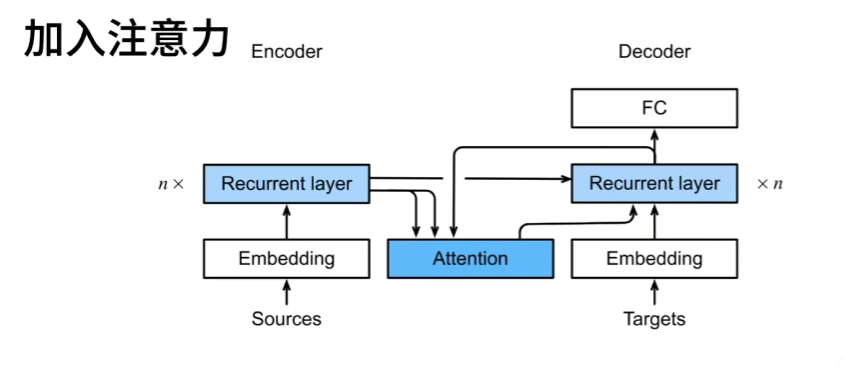

encoder针对原句会输出等长的key-value pair(是第i个词RNN的输出)
解码器RNN对上一个词的输出(上一次的预测)作为query
之前的seq2seq:Decoder接收上一个RNN中最后一个词的输出
改进后:允许拿出所有的词, 再进行加权的分析

·Seq2seq中通过隐状态在编码器和解码器中传递信息
·注意力机制可以根据解码器RNN的输出来匹配到合适的编码器RNN的输出来更有效的传递信息

In [ ]:
# 代码实现
import torch
from torch import nn
from d2l import torch as d2l

In [ ]:
class AttentionDecoder(d2l.Decoder):
    """带有注意力机制的解码器基本接口"""
    def __init__(self, **kwargs):
        super(AttentionDecoder, self).__init__(**kwargs)

    @property
    def attention_weights(self):
        raise NotImplementedError

In [ ]:
class Seq2SeqAttentionDecoder(AttentionDecoder):
    # 类定义和初始化
    # vocab_size: 词汇表大小
    # embed_size: 词嵌入维度
    # num_hiddens: 隐藏层维度
    # num_layers: RNN层数
    # dropout: dropout概率
    def __init__(self, vocab_size, embed_size, num_hiddens, num_layers,
                 dropout=0, **kwargs):
        super(Seq2SeqAttentionDecoder, self).__init__(**kwargs)
        # 网络组件初始化
        self.attention = d2l.AdditiveAttention(num_hiddens, num_hiddens,
                                               num_hiddens, dropout) # self.attention: 加性注意力机制
        self.embedding = nn.Embedding(vocab_size, embed_size) # self.embedding: 词嵌入层
        self.rnn = nn.GRU(embed_size + num_hiddens, num_hiddens, num_layers,
                          dropout=dropout) # self.rnn: GRU循环神经网络，输入维度是embed_size + num_hiddens（因为要拼接上下文向量）
        self.dense = nn.Linear(num_hiddens, vocab_size) # self.dense: 全连接层，输出维度是词汇表大小

    # 初始化状态方法
    def init_state(self, enc_outputs, enc_valid_lens, *args):

        outputs, hidden_state = enc_outputs
        # 返回包含编码器输出、隐藏状态和有效长度的三元组
        return (outputs.permute(1, 0, 2), hidden_state, enc_valid_lens)

    # 前向传播
    def forward(self, X, state):
        enc_outputs, hidden_state, enc_valid_lens = state
        X = self.embedding(X).permute(1, 0, 2)
        outputs, self._attention_weights = [], []
        for x in X:
            query = torch.unsqueeze(hidden_state[-1], dim=1)
            # 调用加性注意力机制
            context = self.attention(query, enc_outputs, enc_outputs,
                                     enc_valid_lens)
            x = torch.cat((context, torch.unsqueeze(x, dim=1)), dim=-1)
            out, hidden_state = self.rnn(x.permute(1, 0, 2), hidden_state)
            outputs.append(out)
            self._attention_weights.append(self.attention.attention_weights)
        outputs = self.dense(torch.cat(outputs, dim=0))
        return outputs.permute(1, 0, 2), [
            enc_outputs, hidden_state, enc_valid_lens]

    @property
    def attention_weights(self):
        return self._attention_weights

In [ ]:
# 测试
encoder = d2l.Seq2SeqEncoder(vocab_size=10, embed_size=8, num_hiddens=16,
                             num_layers=2)
encoder.eval()
decoder = Seq2SeqAttentionDecoder(vocab_size=10, embed_size=8, num_hiddens=16,
                                  num_layers=2)
decoder.eval()
X = torch.zeros((4, 7), dtype=torch.long)
state = decoder.init_state(encoder(X), None)
output, state = decoder(X, state)
output.shape, len(state), state[0].shape, len(state[1]), state[1][0].shape

In [ ]:
# 训练
embed_size, num_hiddens, num_layers, dropout = 32, 32, 2, 0.1
batch_size, num_steps = 64, 10
lr, num_epochs, device = 0.005, 250, d2l.try_gpu()

train_iter, src_vocab, tgt_vocab = d2l.load_data_nmt(batch_size, num_steps)
encoder = d2l.Seq2SeqEncoder(len(src_vocab), embed_size, num_hiddens,
                             num_layers, dropout)
decoder = Seq2SeqAttentionDecoder(len(tgt_vocab), embed_size, num_hiddens,
                                  num_layers, dropout)
net = d2l.EncoderDecoder(encoder, decoder)
d2l.train_seq2seq(net, train_iter, lr, num_epochs, tgt_vocab, device)